In [1]:
import scipy as sp
import scipy.io
import scipy.stats
import os
import numpy as np
import pandas as pd
import glob
import random as rand
from tqdm import tnrange, tqdm_notebook
import sys
sys.path.append(os.getcwd()+'\\..')
import cmocean
from utils import utils
from utils import plotting_utils as pu
from utils import zscores## If exporting figures for adobe illustrator
# import plot_utils_fig5 as pu
from utils import auc_methods
import matplotlib.pylab as mpl
import matplotlib.patches as patches

%load_ext autoreload
%autoreload 2

In [2]:
window = np.array([-0.25, 1])
window_bins = np.arange(*(window+1)/0.025).astype(int)
trial_time = np.arange(*window, 0.025)
bin_size = 0.025

In [3]:
log_df, unit_key_df = utils.load_data(directory = r'C:\Users\efink\Documents\Github\crossmodal\Figure7', switch = True)

In [4]:
log_df['spike_counts'] = log_df['spike_times(stim_aligned)'].apply(lambda x: np.histogram(x, bins = np.arange(-1,3,0.025))[0]/0.025)
unit_key_df = utils.calc_unit_stats(unit_key_df, log_df, bin_size)
log_df = log_df.merge(unit_key_df[['uni_id', 'FR_mean', 'FR_std']], on = 'uni_id')

HBox(children=(IntProgress(value=0, max=375), HTML(value='')))

In [5]:
log_df['mouse_name'].unique()

array(['EF0088', 'EF0094', 'EF0098'], dtype=object)

In [6]:
def calc_z(grp_df):
    mean_sp = np.mean(np.vstack(grp_df['spike_counts'].values), axis = 0)
    z_score = (mean_sp-grp_df.loc[:,'FR_mean'].iloc[0])/grp_df.loc[:,'FR_std'].iloc[0]
    return z_score

In [7]:
grouped_trials = log_df.groupby(['uni_id', 'trial_type', 'response'])
z_scores = grouped_trials.apply(calc_z)

In [8]:
touch_LR_z_score = z_scores.loc[:, 'Stim_Som_NoCue', 1]
activ_resp = touch_LR_z_score.apply(lambda x: sum(x[39:59])/20).reset_index().rename(columns = {0:'active_resp'})

In [9]:
# unit_key_df.loc[~unit_key_df['uni_id'].isin(lick_dir_auc_df['uni_id']), :]

In [10]:
touch_lick_dir_auc_df = pd.read_hdf(r'C:\Users\efink\Documents\Github\calculate_choice_prob\Touch_lick_right_left_switch_auc.h5', 'table')
touch_lick_no_lick_auc_df = pd.read_hdf(r'C:\Users\efink\Documents\Github\calculate_choice_prob\Touch_lick_no_lick_switch_auc.h5', 'table')

visual_lick_dir_auc_df = pd.read_hdf(r'C:\Users\efink\Documents\Github\calculate_choice_prob\Visual_lick_right_left_switch_auc.h5', 'table')
visual_lick_no_lick_auc_df = pd.read_hdf(r'C:\Users\efink\Documents\Github\calculate_choice_prob\Visual_lick_no_lick_switch_auc.h5', 'table')

In [11]:
auc_cols = touch_lick_dir_auc_df.columns.str.contains('auc')
low_cols = touch_lick_dir_auc_df.columns.str.contains('low')
up_cols = touch_lick_dir_auc_df.columns.str.contains('up')

In [12]:
def plot_map_psth(df,ax1,ax2):
    window = np.array([-0.5, 1])
    window_bins = np.arange(*(window+1)/0.025).astype(int)
    trial_time = np.arange(*window, 0.025)

    df = df.merge(activ_resp).sort_values('active_resp').drop(['active_resp'], axis = 1)
    auc = np.vstack(df.loc[:, auc_cols].apply(lambda x: x[window_bins[0]: window_bins[-1]], axis = 1).values)
    xx, yy = np.meshgrid(trial_time[1:], np.arange(0,auc.shape[0]))

    ax1.pcolormesh(xx, yy, auc, vmin = 0.2, vmax = 0.8)
    ax2.plot(trial_time[1:], auc.mean(axis = 0))
    sem = np.std(auc, axis =0)/np.sqrt(auc.shape[0])
    ax2.fill_between(trial_time[1:], auc.mean(axis = 0)-sem, auc.mean(axis = 0)+sem, alpha = 0.5)
    ax2.plot([window[0], window[1]], [0.5, 0.5], 'k--')
    ax2.set_ylim(0.47,0.53)

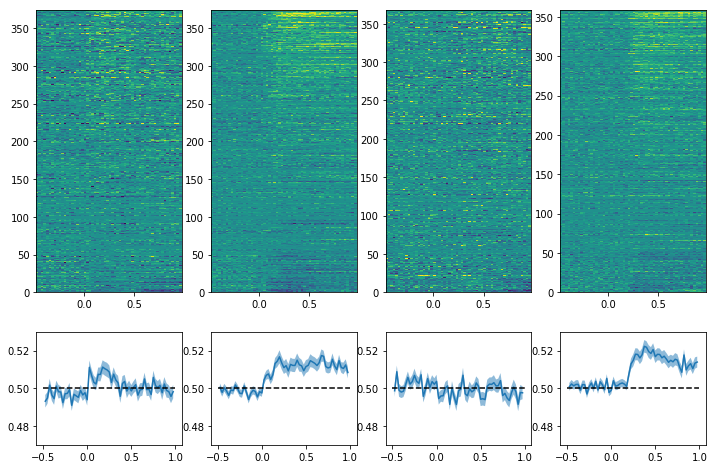

In [13]:
fig,[(ax1, ax2, ax3, ax4), (ax5,ax6,ax7,ax8)] = mpl.subplots(2,4, figsize = (12,8), gridspec_kw={'height_ratios': [2.5,1]})

plot_map_psth(touch_lick_dir_auc_df, ax1,ax5)
plot_map_psth(touch_lick_no_lick_auc_df, ax2,ax6)
plot_map_psth(visual_lick_dir_auc_df.dropna(), ax3,ax7)
plot_map_psth(visual_lick_no_lick_auc_df, ax4,ax8)

In [14]:
def plot_auc_curve(df, ax, color):
    
    window = np.array([-0.25, 1])
    window_bins = np.arange(*(window+1)/0.025).astype(int)
    trial_time = np.arange(*window, 0.025)
    auc = np.vstack(df.loc[:, auc_cols].apply(lambda x: x[window_bins[0]: window_bins[-1]], axis = 1).values)
    sem = np.std(auc, axis =0)/np.sqrt(auc.shape[0])

    ax.plot(trial_time[1:], auc.mean(axis = 0), color = color)
    ax.fill_between(trial_time[1:], auc.mean(axis = 0)-sem, auc.mean(axis = 0)+sem, alpha = 0.5, color = color)
    ax.plot([window[0], window[1]], [0.5, 0.5], 'k--')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(window[0],window[-1])
    ax.set_ylim(0.475,0.525)


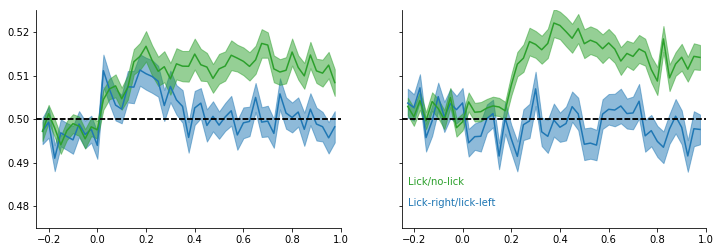

In [15]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize = (12,4), sharey = True, sharex = True)

plot_auc_curve(touch_lick_dir_auc_df, ax1, 'C0')
plot_auc_curve(touch_lick_no_lick_auc_df, ax1, 'C2')

plot_auc_curve(visual_lick_dir_auc_df.dropna(), ax2, 'C0')
plot_auc_curve(visual_lick_no_lick_auc_df, ax2, 'C2')

ax2.text(0.02, 0.2, 'Lick/no-lick', color = 'C2', transform = ax2.transAxes)
ax2.text(0.02, 0.1, 'Lick-right/lick-left', color = 'C0', transform = ax2.transAxes)
fig.savefig('DP_LRvNL_LRvLL.pdf', format = 'pdf', dpi = 900)

In [16]:
%cd C:\Users\efink\Documents\Github\calculate_choice_prob\ 
import calculate_auc as ca


C:\Users\efink\Documents\Github\calculate_choice_prob


In [17]:
def get_spike_counts(unit_df, pos_tt, neg_tt, pos_resp, neg_resp):
    
    pos_trials = (unit_df['trial_type'] == pos_tt) & (unit_df['response'].isin(pos_resp))
    neg_trials = (unit_df['trial_type'] == neg_tt) & (unit_df['response'].isin(neg_resp))

    func = lambda x: np.histogram(x, bins = [0,0.15])[0]/0.15
    spike_counts_pos = unit_df.loc[pos_trials, 'spike_times(stim_aligned)'].apply(func).to_frame()
    spike_counts_neg = unit_df.loc[neg_trials, 'spike_times(stim_aligned)'].apply(func).to_frame()
    
    spike_counts_pos.loc[:, 'label'] = 1
    spike_counts_neg.loc[:, 'label'] = 0
    
    spike_counts = pd.concat([spike_counts_pos,spike_counts_neg]).values
    
    return np.vstack(spike_counts[:,:-1]), spike_counts[:,-1].astype(int)

In [18]:
import scipy.stats as stats

In [19]:
grouped_log = log_df[['uni_id', 'trial_type', 'response', 'spike_times(stim_aligned)']].groupby('uni_id')

spike_counts = [get_spike_counts(unit, 'Stim_Som_NoCue', 'Stim_Som_NoCue', [1], [2]) for _, unit in grouped_log]
auc = [ca.trial_auc(*sp_cnt) for sp_cnt in tqdm_notebook(spike_counts)]
auc = np.squeeze(auc)[:,0]


HBox(children=(IntProgress(value=0, max=375), HTML(value='')))

In [20]:
stats.ttest_1samp(auc, 0.5)
# print(auc)
scipy.stats.ttest_1samp(auc, 0.5)

[0.69405594 0.71853147 0.51398601 0.50909091 0.47954545 0.58409091
 0.47727273 0.46818182 0.62272727 0.46895425 0.48856209 0.47058824
 0.55882353 0.66666667 0.41339869 0.34150327 0.41621622 0.62027027
 0.59189189 0.3972973  0.37837838 0.58243243 0.51351351 0.56351351
 0.44594595 0.49594595 0.64189189 0.52567568 0.46216216 0.48378378
 0.63783784 0.56756757 0.42619048 0.50357143 0.71309524 0.52857143
 0.51666667 0.56428571 0.46190476 0.4952381  0.47142857 0.61785714
 0.57738095 0.43095238 0.70238095 0.5202381  0.55714286 0.40833333
 0.44047619 0.54404762 0.63214286 0.60952381 0.53809524 0.40119048
 0.45952381 0.50714286 0.44       0.55714286 0.57428571 0.69428571
 0.63714286 0.68285714 0.74571429 0.32857143 0.43714286 0.62571429
 0.68571429 0.47714286 0.5        0.58       0.48333333 0.36805556
 0.63194444 0.40555556 0.59305556 0.48611111 0.50277778 0.40277778
 0.59722222 0.48611111 0.74305556 0.40972222 0.41666667 0.16666667
 0.25694444 0.5625     0.35416667 0.65024631 0.72167488 0.5960

Ttest_1sampResult(statistic=3.2890432102634644, pvalue=0.0011006531028480218)

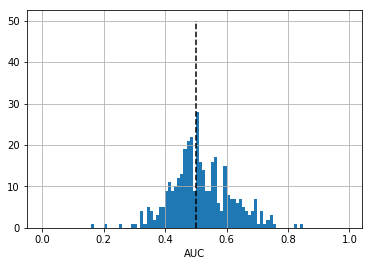

In [21]:
pd.Series(auc).hist(bins = np.arange(0,1, 0.01))
mpl.xlabel('AUC')
mpl.plot([0.5,0.5], [0,50], 'k--')

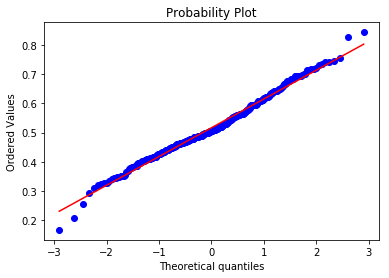

In [26]:
import pylab 

stats.probplot(auc, dist="norm", plot=pylab)
pylab.show()

In [22]:
spike_counts = [get_spike_counts(unit, 'Stim_Som_NoCue', 'Stim_Som_NoCue', [1,2], [0]) for _, unit in grouped_log]
auc2 = [ca.trial_auc(*sp_cnt) for sp_cnt in tqdm_notebook(spike_counts)]
auc2 = np.squeeze(auc2)[:,0]
scipy.stats.ttest_1samp(auc2, 0.5)

HBox(children=(IntProgress(value=0, max=375), HTML(value='')))

KeyboardInterrupt: 

# Sig CP units only

In [ ]:
def calc_sig_auc(auc_df):
    auc_cols = auc_df.columns.str.contains('auc')
    low_cols = auc_df.columns.str.contains('low')
    up_cols = auc_df.columns.str.contains('up')
    
    auc_df = auc_df.fillna(0.5)
    raw_sig_AUC = pd.DataFrame(~((auc_df.loc[:,low_cols] >= 0.5).as_matrix() & (auc_df.loc[:,up_cols] <= 0.5).as_matrix())*1, index = auc_df['uni_id'])
    auc_dir = (auc_df.loc[:,auc_cols] >= 0.5)*1 + (auc_df.loc[:,auc_cols] < 0.5)*-1
    auc_dir.index = auc_df['uni_id']; 
    auc_dir.columns = raw_sig_AUC.columns
    raw_sig_AUC = raw_sig_AUC*auc_dir
    smooth_sig_AUC = raw_sig_AUC.apply(lambda y: np.convolve(y, [1,1,1], 'same'), axis = 1)

    return smooth_sig_AUC

In [ ]:
def find_sig_dp_stats(smooth_auc_df, suffix = ''):
    ### to get the first bin of 3 that are significantly different from 0 need to subtract 1 from all_sig_tac/vis since convolve 
    ### was used with 'same' setting (otherwise would need to subtract 2 if setting was 'full')
    all_sig = (smooth_auc_df.isin([3,-3])*1).apply(lambda y: np.where(y), axis = 1)
    all_sig = all_sig.apply(lambda y: (y[0]-1)*bin_size-1 if len(y[0])>0 else [])
    
    ####### need to subtract 1 bin from both ends because np.histogram counts spikes occuring from and including
    ## the bin label up to but not including the label for bin+1 - this would make it look like activity 
    ## starts before the stimulus onset.
    all_sig = all_sig.apply(lambda y:  y[(y>=0) & (y<3)] if len(y)!=0 else []) 
    all_first_sig = all_sig.apply(lambda y:  np.nan if len(y)==0 else np.min(y))
    all_last_sig = all_sig.apply(lambda y:  np.nan if len(y)==0 else np.max(y))
    sig_stats = pd.merge(all_first_sig.reset_index().rename(columns = {0:'cp_onset_'+suffix}), all_last_sig.reset_index().rename(columns = {0:'cp_offset_'+suffix}))
    
    return sig_stats

In [ ]:
conds = [touch_lick_dir_auc_df, touch_lick_no_lick_auc_df,visual_lick_dir_auc_df, visual_lick_no_lick_auc_df ]
suffixes = ['T_LNL', 'T_LRLL', 'V_LNL', 'V_LRLL']
for cond, suff in zip(conds, suffixes): 
    smooth_sig_auc = calc_sig_auc(cond)
    cp_stats = find_sig_dp_stats(smooth_sig_auc, suffix = suff)
    unit_key_df = unit_key_df.merge(cp_stats)

In [ ]:
touch_lick_units

sub_lick_dir_auc_df = lick_dir_auc_df.merge(touch_lick_units, on ='uni_id')
sub_lick_dir_auc_df = sub_lick_dir_auc_df.merge(activ_resp).sort_values('active_resp').drop(['active_resp'], axis = 1)
auc = np.vstack(sub_lick_dir_auc_df.loc[:, auc_cols].apply(lambda x: x[window_bins[0]: window_bins[-1]], axis = 1).values)

sub_lick_no_lick_auc_df = lick_no_lick_auc_df.merge(touch_lick_units, on ='uni_id')
sub_lick_no_lick_auc_df = sub_lick_no_lick_auc_df.merge(activ_resp).sort_values('active_resp').drop(['active_resp'], axis = 1)
auc_lick_no_lick = np.vstack(sub_lick_no_lick_auc_df.loc[:, auc_cols].apply(lambda x: x[window_bins[0]: window_bins[-1]], axis = 1).values)

fig,[(ax1, ax3), (ax2, ax4)] = mpl.subplots(2,2, figsize = (6,8), gridspec_kw={'height_ratios': [2.5,1]})
xx, yy = np.meshgrid(trial_time[1:], np.arange(0,auc.shape[0]))
xx2, yy2 = np.meshgrid(trial_time[1:], np.arange(0,auc_lick_no_lick.shape[0]))

ax1.pcolormesh(xx, yy, auc, vmin = 0.2, vmax = 0.8)
ax2.plot(trial_time[1:], auc.mean(axis = 0))
sem = np.std(auc, axis =0)/np.sqrt(auc.shape[0])
ax2.fill_between(trial_time[1:], auc.mean(axis = 0)-sem, auc.mean(axis = 0)+sem, alpha = 0.5)
ax2.set_ylim(0.47,0.55)

ax3.pcolormesh(xx2, yy2, auc_lick_no_lick, vmin = 0.2, vmax = 0.8)
ax4.plot(trial_time[1:], auc_lick_no_lick.mean(axis = 0))
sem = np.std(auc_lick_no_lick, axis =0)/np.sqrt(auc.shape[0])
ax4.fill_between(trial_time[1:], auc_lick_no_lick.mean(axis = 0)-sem, auc_lick_no_lick.mean(axis = 0)+sem, alpha = 0.5)
ax4.set_ylim(0.47,0.55)


In [ ]:
sig_units = unit_key_df.loc[~unit_key_df.loc[:,['cp_onset_T_LNL', 'cp_onset_V_LNL']].isnull().all(axis = 1), 'uni_id']
sig_units.shape

In [ ]:
sig_touch_lick_dir_auc_df = touch_lick_dir_auc_df[touch_lick_dir_auc_df['uni_id'].isin(sig_units)]
sig_touch_lick_no_lick_auc_df = touch_lick_no_lick_auc_df[touch_lick_no_lick_auc_df['uni_id'].isin(sig_units)]
sig_visual_lick_dir_auc_df = visual_lick_dir_auc_df[visual_lick_dir_auc_df['uni_id'].isin(sig_units)]
sig_visual_lick_no_lick_auc_df = visual_lick_no_lick_auc_df[visual_lick_no_lick_auc_df['uni_id'].isin(sig_units)]

In [ ]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize = (12,4), sharey = True, sharex = True)

plot_auc_curve(sig_touch_lick_dir_auc_df, ax1, 'C0')
plot_auc_curve(sig_touch_lick_no_lick_auc_df, ax1, 'C2')

plot_auc_curve(sig_visual_lick_dir_auc_df, ax2, 'C0')
plot_auc_curve(sig_visual_lick_no_lick_auc_df, ax2, 'C2')

ax2.text(0.02, 0.2, 'Lick/no-lick', color = 'C2', transform = ax2.transAxes)
ax2.text(0.02, 0.1, 'Lick-right/lick-left', color = 'C0', transform = ax2.transAxes)
# fig.savefig('DP_LRvNL_LRvLL.pdf', format = 'pdf', dpi = 900)

ax1.set_ylim(0.46,0.55)

In [ ]:
stats.probplot(measurements, dist="norm", plot=pylab)
